# Domača naloga 2

## Naloga 1: SVM (4 točke)

1.a (3 točke): Slika prikazuje odločitvene meje za različne modele podpornih vektorjev. Modri krogci predstavljajo ciljno vrednost -1, rdeče pa ciljno vrednost 1. Podporni vektorji so prikazani z izpolnjenim krogcem. Vsaki odločitveni meji priredi jedro, s katerim je bila naučena in svoja prirejanja utemelji.

1. Linearno jedro, $C=0.05$
2. Linearno jedro, $C=20$
3. Polinomsko jedro stopnje 2, $C=0.05$
4. Polinomsko jedro stopnje 2, $C=20$
5. Polinomsko jedro stopnje 3, $C=0.05$
6. Gaussovo jedro, $C=1$

![alt text](svm.png)

1.b (1 točka): Kako vrednost parametra $C$ vpliva na odločitveno mejo? Kaj je prednost modela iz slike (a) in tistega iz slike (e)?

## Naloga 2: Ansambli

2.a (0.5 točke): Dopolni funkcijo `izberi_podmnozico(x, n)`, ki naključno izbere $n$ napovednih spremenljivk in funkcijo `zankaj(x)`, ki vrne (multi)množico indeksov podatkov, dobljenih z vzorčenjem z zankanjem.

In [1]:
import numpy as np
import random as r
np.random.seed(18)
r.seed(42)

In [2]:
def izberi_podmnozico(x, num_features):
    if num_features >= len(x[0]):
        return np.array([i for i in range(len(x[0]))])
    else: 
        return np.array(sorted(r.sample([i for i in range(len(x[0]))], k=num_features)))

In [3]:
def zankaj(x):
    return np.array(r.choices([i for i in range(len(x))], k=len(x)), dtype=np.int64)

In [4]:
x = np.random.random((10, 12))

assert izberi_podmnozico(x, 3).shape == (3, )

assert izberi_podmnozico(x, 4).shape == (4, )

assert izberi_podmnozico(x, 15).shape == (12, )

assert zankaj(x).shape == (10, )

assert zankaj(x).dtype == np.int64

2.b (2 točki): Z zgoraj definiranima funkcijama lahko dobimo podmnožice podatkov za gradnjo ansambla regresijskih napovednih modelov tipa vrečenja. Dopolni razred Vrečenje, ki vreči *st_modelov* osnovnih modelov. Vsak osnovni model naj bo naučen na podmnožici *st_spremenljivk* naključno izbranih napovednih spremenljivk.  

Namig: Kopijo naučenega osnovnega modela lahko dobiš s funkcijo `sklearn.base.clone`.

In [5]:
from sklearn.base import clone

class Vrecenje:
    def __init__(self, st_modelov, st_spremenljivk, osnovni_model):
        self.n = st_modelov
        self.spr = st_spremenljivk
        self.om = osnovni_model
        self.modeli = []
        self.spr_x = []

    def natreniraj(self, x_train, y_train):
        for _ in range(self.n):
            index = izberi_podmnozico(x_train, self.spr)
            self.spr_x.append(index)
            x_index = [[data[i] for i in index] for data in x_train]
            x_index_vzorec = zankaj(x_index)

            x_vzorec = [x_index[vz] for vz in x_index_vzorec]
            y_vzorec = [y_train[vz] for vz in x_index_vzorec]

            kopiran_model = clone(self.om)
            model = kopiran_model.fit(x_vzorec, y_vzorec)
            self.modeli.append(model)

        return self

    def napovej(self, x_test):
        y_pred_lst = []
        
        for i, model in enumerate(self.modeli):
            y_pred = model.predict([[data[j] for j in self.spr_x[i]] for data in x_test])
            y_pred_lst.append(y_pred)
            
        return np.mean(y_pred_lst, axis = 0)

2.c (1.5 točke): Na podatkih iz datoteke `dn2_2.npz` oceni točnost ansambelskega napovednega modela iz naloge 2.b. Kot osnovni model uporabi odločitveno drevo. Poročaj pri kateri vrednosti parametra *st_spremenljivk* je model najbolj točen in ob kakšni vrednosti parametra *st_modelov* se točnost napovednega modela ne izboljšuje več bistveno. Najboljši ansambelski model primerjaj z enim samim odločitvenim drevesom.

st_modelov = 25, st_spremenljivk = 1 : 8.685
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 2 : 6.129
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 3 : 4.38
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 4 : 3.85
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 5 : 4.017
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 6 : 4.235
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 7 : 4.186
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 8 : 4.138
--------------------------------------------------
min povp RMSE pri st_spremenljivk = 4


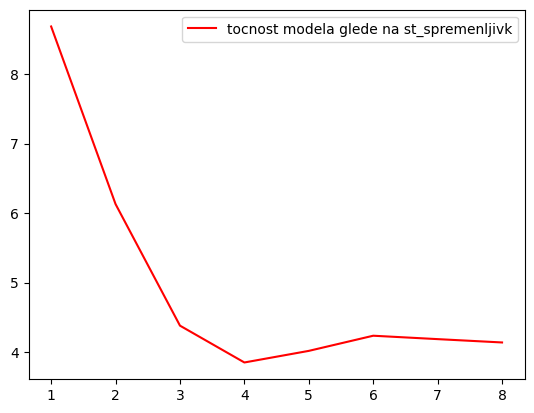

st_modelov = 1, st_spremenljivk = 4 : 7.864
--------------------------------------------------
st_modelov = 2, st_spremenljivk = 4 : 5.913
--------------------------------------------------
st_modelov = 3, st_spremenljivk = 4 : 5.395
--------------------------------------------------
st_modelov = 4, st_spremenljivk = 4 : 5.047
--------------------------------------------------
st_modelov = 5, st_spremenljivk = 4 : 4.999
--------------------------------------------------
st_modelov = 10, st_spremenljivk = 4 : 4.112
--------------------------------------------------
st_modelov = 15, st_spremenljivk = 4 : 4.085
--------------------------------------------------
st_modelov = 20, st_spremenljivk = 4 : 3.952
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 4 : 3.968
--------------------------------------------------
st_modelov = 50, st_spremenljivk = 4 : 3.954
--------------------------------------------------
st_modelov = 60, st_spremenljivk = 4 : 3.823


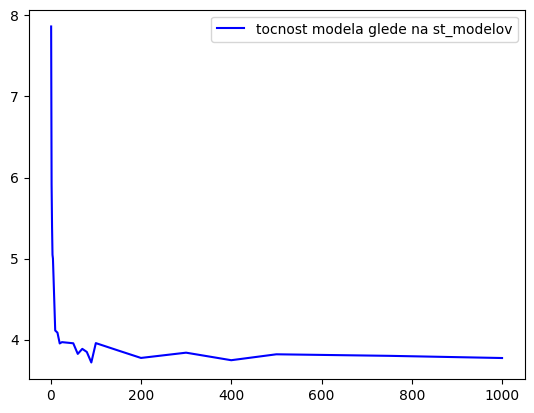

eno odlocitveno drevo rmse: 5.31
--------------------------------------------------


In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

def celotno_vrecenje(x, y, osnovni_model, st_spr, st_modelov):

    np.random.seed(18)
    kfold = KFold(shuffle=True)
    errors = []

    for _, (train_idx, test_idx) in enumerate(kfold.split(x)):

        x_train = x[train_idx]
        y_train = y[train_idx] 
        x_test = x[test_idx]
        y_test = y[test_idx]

        model = Vrecenje(st_modelov, st_spr, osnovni_model).natreniraj(x_train, y_train)
        y_pred = model.napovej(x_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        errors.append(rmse)

    mean_rmse = round(np.mean(errors), 3)
    print(f"st_modelov = {st_modelov}, st_spremenljivk = {st_spr} : {mean_rmse}")
    print("--------------------------------------------------")

    return mean_rmse

#---------------------------------------------------------------------------------

data = np.load("dn2_2.npz")
x = data["x"]
y = data["y"]


for i in range(len(x)):
    for j in range(len(x[0])):
        if math.isnan(x[i][j]):
            x[i][j] = 0

max_spr = len(x[0])

osnovni_model = DecisionTreeRegressor()

#test_run = celotno_vrecenje(x, y, osnovni_model, 4, 10)

# NAJBOLJ TOCEN GLEDE NA st_spremenljivk
#---------------------------------------------------------------------------------
errs_k = []

for k in range(max_spr):
    err_k = celotno_vrecenje(x, y, osnovni_model, k + 1, 25)
    errs_k.append(err_k)

print(f"min povp RMSE pri st_spremenljivk = {errs_k.index(min(errs_k)) + 1}")
min_st_spr = errs_k.index(min(errs_k)) + 1

plt.plot([k+1 for k in range(max_spr)], errs_k, color='r', label='tocnost modela glede na st_spremenljivk') 
plt.legend() 
plt.show()


# NAJBOLJ TOCEN GLEDE NA st_modelov 
#---------------------------------------------------------------------------------
errs_j = []
st_m = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500, 750, 1000]

for n_m in st_m:
    err_j = celotno_vrecenje(x, y, osnovni_model, min_st_spr, n_m)
    errs_j.append(err_j)

print("--------------------------------------------------------")
print(f"min povp RMSE pri st_modelov = {st_m[errs_j.index(min(errs_j))]}")
min_st_mod = st_m[errs_j.index(min(errs_j))]
print("--------------------------------------------------------")

plt.plot(st_m, errs_j, color='b', label='tocnost modela glede na st_modelov') 
plt.legend() 
plt.show()

#primerjajmo najboljsi model Vrecenja z enim samim odlocitvenim drevesom
#najboljsi = celotno_vrecenje(x, y, osnovni_model, min_st_spr, min_st_mod)

def eno_odlocitveno_drevo(x, y):
    kfold = KFold(shuffle=True)
    errs = []

    for _, (train_idx, test_idx) in enumerate(kfold.split(x)):
        x_train = x[train_idx]
        y_train = y[train_idx]
        x_test = x[test_idx]
        y_test = y[test_idx]
        model = DecisionTreeRegressor().fit(x_train, y_train)
        y_pred = model.predict(x_test)
        err = np.sqrt(mean_squared_error(y_test, y_pred))
        errs.append(err)

    print(f"eno odlocitveno drevo rmse: {round(np.mean(errs), 3)}")
    print("--------------------------------------------------")
    return round(np.mean(errs), 3)

eno_drevo = eno_odlocitveno_drevo(x, y)


2.d (2 točki): Vrečeni modeli se med seboj razlikujejo po zmogljivosti (napovedni napaki). Zmogljivost našega modela lahko torej izboljšamo tako, da napovedi osnovnih modelov kombiniramo z obteženim povprečjem. Premisli kako bi napovedi vrečenih modelov obtežil in popravi model iz naloge 2.b (definiraj razred UtezenoVrečenje). Poročaj, kakšna je točnost novega modela in opiši, kako si napovedi vrečenih modelov obtežil.

st_modelov = 25, st_spremenljivk = 1 : 8.43
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 2 : 5.846
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 3 : 3.995
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 4 : 3.719
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 5 : 3.675
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 6 : 3.567
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 7 : 3.863
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 8 : 4.043
--------------------------------------------------
--------------------------------------------------------
min povp RMSE pri st_spremenljivk = 6
--------------------------------------------------------


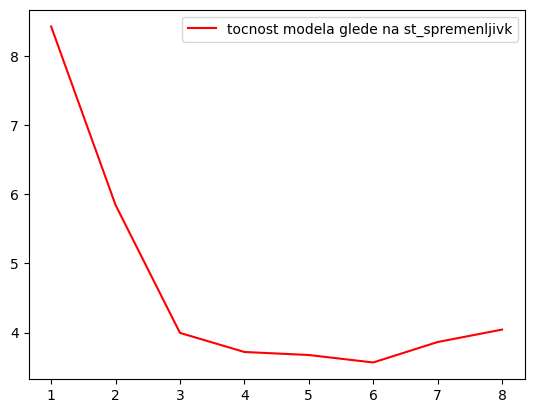

st_modelov = 1, st_spremenljivk = 6 : 5.146
--------------------------------------------------
st_modelov = 2, st_spremenljivk = 6 : 5.601
--------------------------------------------------
st_modelov = 3, st_spremenljivk = 6 : 4.375
--------------------------------------------------
st_modelov = 4, st_spremenljivk = 6 : 4.305
--------------------------------------------------
st_modelov = 5, st_spremenljivk = 6 : 4.324
--------------------------------------------------
st_modelov = 10, st_spremenljivk = 6 : 3.873
--------------------------------------------------
st_modelov = 15, st_spremenljivk = 6 : 3.734
--------------------------------------------------
st_modelov = 20, st_spremenljivk = 6 : 3.505
--------------------------------------------------
st_modelov = 25, st_spremenljivk = 6 : 3.378
--------------------------------------------------
st_modelov = 50, st_spremenljivk = 6 : 3.485
--------------------------------------------------
st_modelov = 60, st_spremenljivk = 6 : 3.466


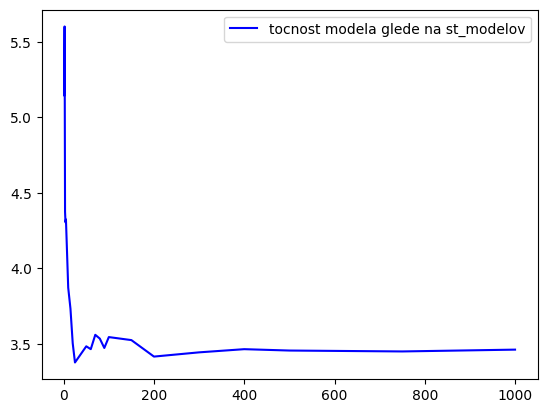

In [7]:
class UtezenoVrecenje:
    def __init__(self, st_modelov, st_spremenljivk, osnovni_model):
        self.n = st_modelov
        self.spr = st_spremenljivk
        self.om = osnovni_model
        self.modeli = []
        self.spr_x = []

    def natreniraj(self, x_train, y_train):
        for _ in range(self.n):
            index = izberi_podmnozico(x_train, self.spr)
            self.spr_x.append(index)
            x_index = [[data[i] for i in index] for data in x_train]
            x_index_vzorec = zankaj(x_index)

            x_vzorec = [x_index[vz] for vz in x_index_vzorec]
            y_vzorec = [y_train[vz] for vz in x_index_vzorec]

            kopiran_model = clone(self.om)
            model = kopiran_model.fit(x_vzorec, y_vzorec)
            self.modeli.append(model)

        return self

    def napovej(self, x_test, y_test):
        y_pred_lst = []
        inv_rmse_models = []
        
        for i, model in enumerate(self.modeli):
            y_pred = model.predict([[data[j] for j in self.spr_x[i]] for data in x_test])
            y_pred_lst.append(y_pred)

            rmse_mod = np.sqrt(mean_squared_error(y_pred, y_test))
            inv_rmse_models.append(1/rmse_mod)

        sum_rmse = np.sum(inv_rmse_models)
        w = [inv_rmse/sum_rmse for inv_rmse in inv_rmse_models]
        y_pred_lst_w = [w[j] * y_pred_lst[j] for j in range(len(y_pred_lst))]

        y_final_pred = sum(y_pred_lst_w)

        return y_final_pred

#---------------------------------------------------------------------------------------------------
    
def celotno_utezeno_vrecenje(x, y, osnovni_model, st_spr, st_modelov):

    np.random.seed(18)
    kfold = KFold(shuffle=True)
    errors = []

    for _, (train_idx, test_idx) in enumerate(kfold.split(x)):

        x_train = x[train_idx]
        y_train = y[train_idx] 
        x_test = x[test_idx]
        y_test = y[test_idx]

        model = UtezenoVrecenje(st_modelov, st_spr, osnovni_model).natreniraj(x_train, y_train)
        y_pred = model.napovej(x_test, y_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        errors.append(rmse)

    mean_rmse = round(np.mean(errors), 3)
    print(f"st_modelov = {st_modelov}, st_spremenljivk = {st_spr} : {mean_rmse}")
    print("--------------------------------------------------")

    return mean_rmse
    
# NAJBOLJ TOCEN GLEDE NA st_spremenljivk 
#---------------------------------------------------------------------------------

errs_k = []

for k in range(max_spr):
    err_k = celotno_utezeno_vrecenje(x, y, osnovni_model, k + 1, 25)
    errs_k.append(err_k)

print("--------------------------------------------------------")
print(f"min povp RMSE pri st_spremenljivk = {errs_k.index(min(errs_k)) + 1}")
min_st_spr = errs_k.index(min(errs_k)) + 1
print("--------------------------------------------------------")

plt.plot([k+1 for k in range(max_spr)], errs_k, color='r', label='tocnost modela glede na st_spremenljivk') 
plt.legend() 
plt.show()


# NAJBOLJ TOCEN GLEDE NA st_modelov 
#---------------------------------------------------------------------------------
errs_j = []
st_m = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400, 500, 750, 1000]

for n_m in st_m:
    err_j = celotno_utezeno_vrecenje(x, y, osnovni_model, min_st_spr, n_m)
    errs_j.append(err_j)

print("--------------------------------------------------------")
print(f"min povp RMSE pri st_modelov = {st_m[errs_j.index(min(errs_j))]}")
min_st_mod = st_m[errs_j.index(min(errs_j))]
print("--------------------------------------------------------")

plt.plot(st_m, errs_j, color='b', label='tocnost modela glede na st_modelov') 
plt.legend() 
plt.show()

## Naloga 3: Nevronske mreže (4 točke)

3.a (0.5 točke): Preberi podatke (slike) iz datotek za učno in testno množico `dn2_3_train.npz` in `dn2_3_test.npz` ter jih pripravi za uporabo z nevronskimi mrežami (knjižico `PyTorch`).

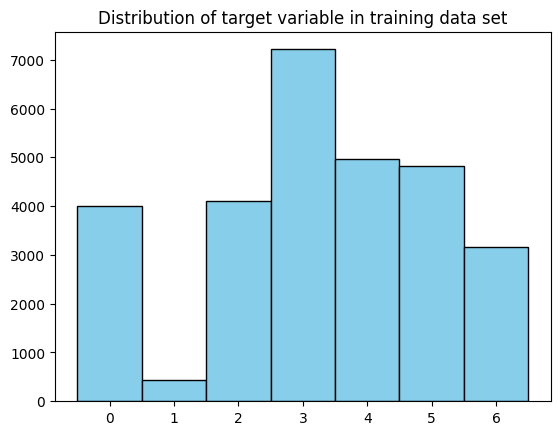

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from sklearn.utils import shuffle
from torch.utils.data import Dataset

data_train = np.load("dn2_3_train.npz")
data_test = np.load("dn2_3_test.npz")

x_train3times = data_train["x"]
y_train_non_shuffled = data_train["y"]
x_test3times = data_test["x"]
y_test_non_shuffled = data_test["y"]

x_train_non_shuffled = [[x[0]] for x in x_train3times]
x_test_non_shuffled = [[x[0]] for x in x_test3times]

x_train, y_train = shuffle(x_train_non_shuffled, y_train_non_shuffled, random_state=18)
x_test, y_test = shuffle(x_test_non_shuffled, y_test_non_shuffled, random_state=18)

bin_edges = np.arange(-0.5, 6.5 + 1, 1)
plt.hist(y_train, bins = bin_edges, color='skyblue', edgecolor='black')
plt.title("Distribution of target variable in training data set")
plt.show()

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(np.array(x))
        self.y = np.array(y)

        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        return x, y

#transform = transforms.Compose([
#     #transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with probability 0.5
#     #transforms.RandomVerticalFlip(p=0.5),    # Flip images vertically with probability 0.5
#    transforms.RandomRotation(degrees=10),    # Randomly rotate images by up to 10 degrees
#    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Adjust brightness, contrast, saturation, and hue # Randomly crop and resize images
#    transforms.RandomAffine(degrees=(-15, 15), translate=(0.1, 0.1), scale=(0.9, 1.1))# Apply random affine transformations
#])
#
#class CustomDataset2(Dataset):
#    def __init__(self, x, y, transform, train = True):
#        self.x = torch.tensor(np.array(x))
#        self.y = np.array(y)
#        self.transform = transform
#        self.train = train
#        
#    def __len__(self):
#        return len(self.x)
#    
#    def __getitem__(self, idx):
#        x = self.x[idx]
#        y = self.y[idx]
#
#        if self.transform and self.train:
#            x = self.transform(x)
#        
#        return x, y
#    
#d_train2 = CustomDataset2(x_train, y_train, transform, True)
#d_test2 = CustomDataset2(x_test, y_test, transform, False)

d_train = CustomDataset(x_train, y_train)
d_test = CustomDataset(x_test, y_test)

3.b (3.5 točke): Z uporabo nevronskih mrež se poskušaj iz učne množice naučiti model za klasifikacijo, ki dosega čim višjo vrednost mere zmogljivosti F1 na testni množici. Poleg tega poročaj točnost za vsak razred (ciljno vrednost).

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            #46

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
            #22

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
            #10

            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),
            #8

            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
            #3
            
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.35),
            #1
            )
        
        self.fc = nn.Linear(512, 7)


    def forward(self, x):
        x = self.convolution(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [10]:
from sklearn.metrics import f1_score

def test(model, testset, batch_size):
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    counter = 0
    all_true = []
    all_pred = []
    class_correct = [0] * 7
    class_total = [0] * 7
    
    with torch.no_grad():
        with tqdm(total=len(testloader)*batch_size, desc=f'Testing', unit='chunks') as prog_bar:
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                output = model(inputs)
                test_loss += criterion(output, labels).detach().item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(labels.data.view_as(pred)).sum()
                prog_bar.update(batch_size)
                
                for label, prediction in zip(labels, pred.view(-1)):
                    class_correct[label] += int(label == prediction)
                    class_total[label] += 1
                

                counter += 1

                all_true.extend(labels.cpu().numpy())
                all_pred.extend(pred.cpu().numpy().flatten())

    f1 = f1_score(all_true, all_pred, average='weighted')
    class_accuracy = [c / t if t != 0 else 0 for c, t in zip(class_correct, class_total)]
    
    print(f'Test set: Avg. loss: {test_loss/counter}, Correct predictions: {correct}/{len(testloader.dataset)}, Percent of correct predictions : {correct/len(testloader.dataset)}, F1 Score: {f1}')
    print("-----------------------------------------------------")
    for i in range(7):
        print(f'Class {i}: {class_accuracy[i]}')
    print("-----------------------------------------------------")
    return f1

In [11]:
def train(epochs, model, trainset, batch_size, current_best, learning_rate=0.01):
    model.load_state_dict(torch.load('model.pth'))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.load_state_dict(torch.load('model.pth'))
        model.train()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        running_loss = 0.0
        with tqdm(total=len(trainloader)*batch_size, desc=f'Training - Epoch: {epoch + 1}/{epochs}', unit='chunks') as prog_bar:
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.detach().item()
                prog_bar.set_postfix(**{'loss': (running_loss) / (i+1)})
                prog_bar.update(batch_size)
    
        new = test(model, d_test, batch_size)
        if new > current_best:
            torch.save(model.state_dict(), 'model.pth')
            current_best = new
            
    print('Finished Training')

In [12]:
torch.manual_seed(42)
model = CNN()
model.load_state_dict(torch.load('model.pth'))
#epochs = 1
batch_size = 64
#
#print("Accuracy on the test set before training")
#print(end="")
#current_best = test(model, d_test, batch_size)
#print()
#
#train(epochs, model, d_train, batch_size, current_best)
#print()
#
#model.load_state_dict(torch.load('model.pth'))
#print("Accuracy on the test set after training the model")
new_best = test(model, d_test, batch_size)

Testing: 100%|██████████| 7232/7232 [00:25<00:00, 283.57chunks/s]

Test set: Avg. loss: 1.4228139092436933, Correct predictions: 4272/7178, Percent of correct predictions : 0.5951518416404724, F1 Score: 0.5940126275154392
-----------------------------------------------------
Class 0: 0.48538622129436326
Class 1: 0.4594594594594595
Class 2: 0.4072265625
Class 3: 0.7976324689966178
Class 4: 0.5725871857258719
Class 5: 0.4859663191659984
Class 6: 0.7364620938628159
-----------------------------------------------------
